In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
print(f"Versión de Python: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")


check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

# Data Type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   


2025-03-07 15:46:42.392568: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 15:46:42.399941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741373202.409985   35310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741373202.413158   35310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 15:46:42.424054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Versión de Python: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:48:41) [GCC 13.3.0]
TensorFlow version: 2.18.0
Numpy version: 2.2.3
Matplotlib version: 3.10.1
GPU is available


In [110]:
# Loading models
#model_1 = tf.keras.models.load_model("red_vaso_1_5Mar.h5")
#model_2 = tf.keras.models.load_model("red_vaso_2_5Mar.h5")
#model_2 = tf.keras.models.load_model("red_vaso_3_5Mar.h5")

# Clinical Measurements

In [3]:
input_vessel_1 = np.load("input_arteria12Nov.npy", allow_pickle=True).item()
output_vessel_2 = np.load("input_arteria22Nov.npy", allow_pickle=True).item()
output_vessel_3 = np.load("input_arteria32Nov.npy", allow_pickle=True).item()

    
velocity_measurements_vessel1 = input_vessel_1["Velocidad"][:,None]
velocity_measurements_vessel2 = output_vessel_2["Velocidad"][:,None]
velocity_measurements_vessel3 = output_vessel_3["Velocidad"][:,None]

    
area_measurements_vessel1 = input_vessel_1["Area"][:,None]
area_measurements_vessel2 = output_vessel_2["Area"][:,None]
area_measurements_vessel3 = output_vessel_3["Area"][:,None]

t_med = input_vessel_1["Tiempo"][:,None]
t_min_mesurement = t_med.min()

N_u = len(t_med)   

# Measurements of the area and velocity at the entrance of the vessel
u_in = tf.constant(velocity_measurements_vessel1 , dtype = DTYPE)
A_in = tf.constant(area_measurements_vessel1 , dtype = DTYPE)

# Measurements of the area and velocity at the exit of the second vessel
u_out = tf.constant(velocity_measurements_vessel2 , dtype = DTYPE)
A_out = tf.constant(area_measurements_vessel2 , dtype = DTYPE)

# Measurements of the area and velocity at the exit of the third vessel
u_out3 = tf.constant(velocity_measurements_vessel3 , dtype = DTYPE)
A_out3 = tf.constant(area_measurements_vessel3 , dtype = DTYPE)



2025-03-05 12:29:47.821981: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-05 12:29:47.822021: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-05 12:29:47.822027: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-05 12:29:47.822590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-05 12:29:47.822936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


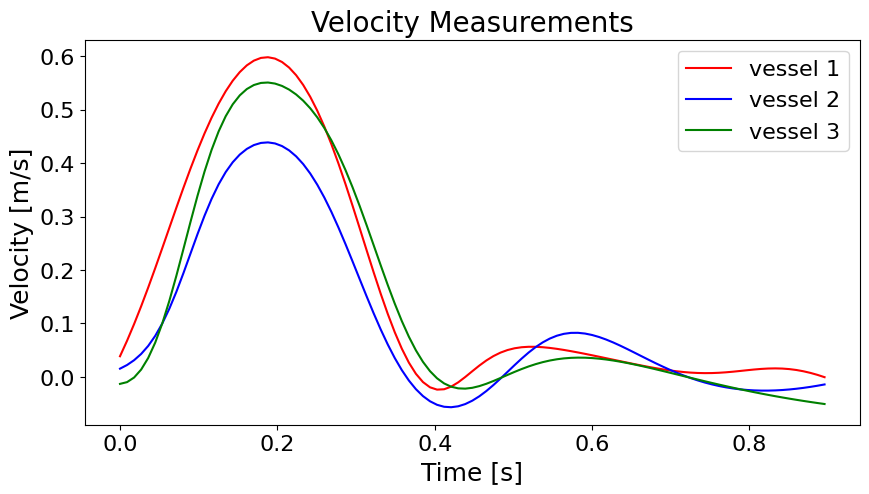

In [4]:
plt.figure(figsize=(10,5))
plt.plot(t_med, velocity_measurements_vessel1, color = 'r' , label = 'vessel 1')
plt.plot(t_med, velocity_measurements_vessel2, color = 'b', label = 'vessel 2' )
plt.plot(t_med, velocity_measurements_vessel3 , color = 'g', label = 'vessel 3' )
plt.xlabel('Time [s]', fontsize = 18)
plt.ylabel('Velocity [m/s]', fontsize = 18)
plt.title('Velocity Measurements', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

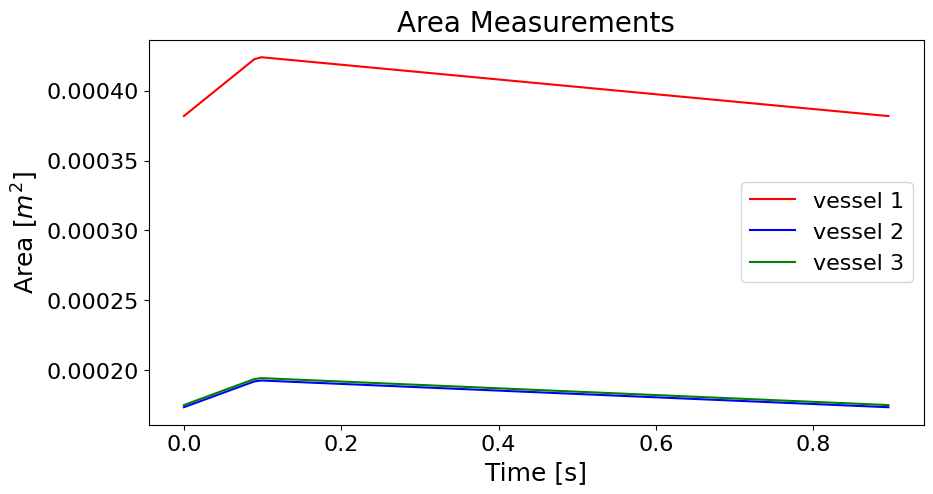

In [5]:
plt.figure(figsize=(10,5))
plt.plot(t_med, area_measurements_vessel1, color = 'r' , label = 'vessel 1')
plt.plot(t_med, area_measurements_vessel2, color = 'b', label = 'vessel 2' )
plt.plot(t_med, area_measurements_vessel3 , color = 'g', label = 'vessel 3' )
plt.xlabel('Time [s]', fontsize = 18)
plt.ylabel('Area [$m^2$]', fontsize = 18)
plt.title('Area Measurements', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()


# Colocation Points

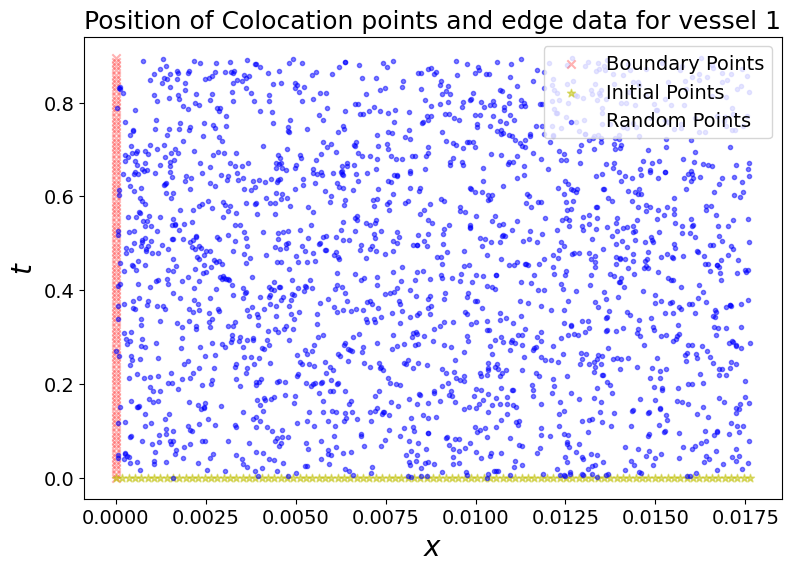

In [6]:
# Vessel 1
tmin = 0.000
tmax = 0.89552239 
xmin_1 = 0
xmax_1 = 0.01763 

lb1 = tf.constant([tmin, xmin_1], dtype = DTYPE)
ub1 = tf.constant([tmax, xmax_1], dtype = DTYPE)

x_r1 = tf.constant(lb1[1]+ (ub1[1] - lb1[1])*np.random.random(2000), shape = (2000,1), dtype = DTYPE)
t_r = tf.constant(lb1[0]+ (ub1[0] - lb1[0])*np.random.random(2000), shape = (2000,1), dtype = DTYPE)
X_r1 = tf.concat([x_r1, t_r], axis = 1) 


# Boundary Points
x_in =tf.ones((N_u,1), dtype = DTYPE)*xmin_1
t_0 = tf.constant(t_med , dtype = DTYPE)
X_in = tf.concat([x_in, t_0], axis = 1)
x_in_epsilon =tf.ones((N_u,1), dtype = DTYPE)*(xmin_1)

# Initial Points 
X_vessel1 = np.linspace(xmin_1, xmax_1, N_u)[:,None]
X_initial_vessel1 = tf.constant(X_vessel1 , dtype = DTYPE)
t_inicial =tf.ones((N_u,1), dtype = DTYPE)*t_min_mesurement
X_01 = tf.concat([X_initial_vessel1, t_inicial], axis = 1) 

# Plot 
fig = plt.figure(figsize = (9,6))
plt.title('Position of Colocation points and edge data for vessel 1', fontsize = 18)
plt.scatter( x_in, t_0 , c= 'r', marker = 'x', alpha = 0.3, label = 'Boundary Points')
plt.scatter( X_initial_vessel1, t_inicial , c= 'y', marker = '*', alpha = 0.5, label = 'Initial Points')
plt.scatter( x_r1, t_r, c = 'b', marker = '.', alpha = 0.5, label = 'Random Points')
plt.xlabel('$x$', fontsize = 20)
plt.ylabel('$t$', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

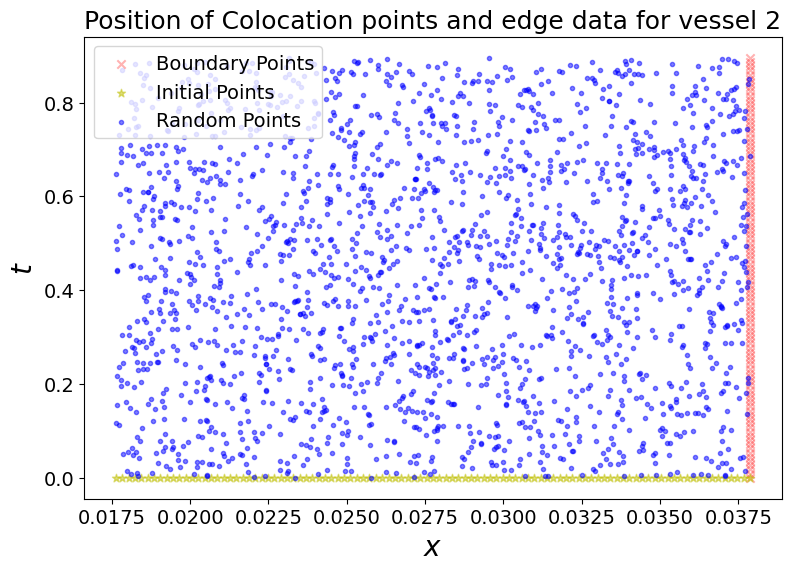

In [7]:
# Vessel 2
tmin = 0.000
tmax = 0.89552239  
xmin_2 = 0.01763 
xmax_2 = 0.03787 

lb2 = tf.constant([tmin, xmin_2], dtype = DTYPE)
ub2 = tf.constant([tmax, xmax_2], dtype = DTYPE)

x_r2 = tf.constant(lb2[1]+ (ub2[1] - lb2[1])*np.random.random(2000), shape = (2000,1), dtype = DTYPE)
X_r2 = tf.concat([x_r2, t_r], axis = 1) 

# Boundary Points
x_out2 =tf.ones((N_u,1), dtype = DTYPE)*xmax_2
t_0 = tf.constant(t_med , dtype = DTYPE)
X_out_2 = tf.concat([x_out2, t_0], axis = 1)

# Initial Points
X_vessel2 = np.linspace(xmin_2, xmax_2, N_u)[:,None]
X_initial_vessel2 = tf.constant(X_vessel2 , dtype = DTYPE)
t_inicial =tf.ones((N_u,1), dtype = DTYPE)*t_min_mesurement
X_02 = tf.concat([X_initial_vessel2, t_inicial], axis = 1) 

# Plot
fig = plt.figure(figsize = (9,6))
plt.title('Position of Colocation points and edge data for vessel 2', fontsize = 18)
plt.scatter( x_out2, t_0 , c= 'r', marker = 'x', alpha = 0.3, label = 'Boundary Points')
plt.scatter( X_initial_vessel2, t_inicial , c= 'y', marker = '*', alpha = 0.5, label = 'Initial Points')
plt.scatter( x_r2, t_r, c = 'b', marker = '.', alpha = 0.5, label = 'Random Points')
plt.xlabel('$x$', fontsize = 20)
plt.ylabel('$t$', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

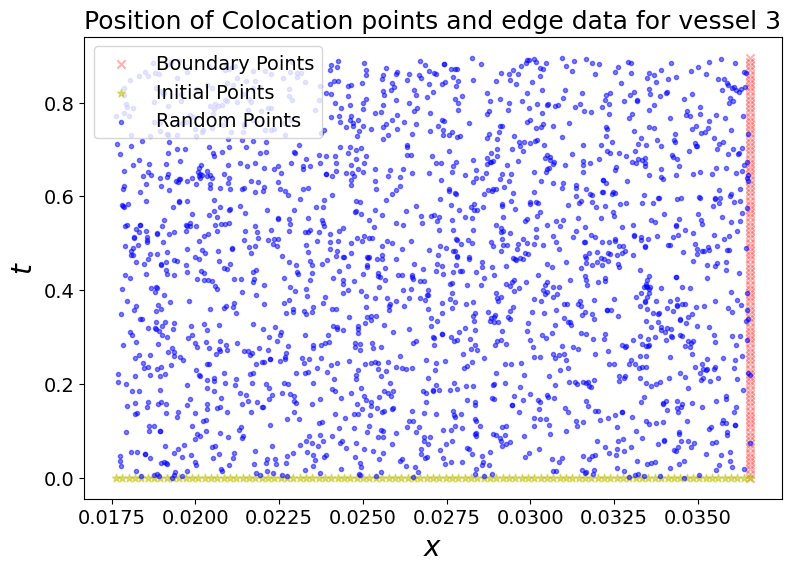

In [8]:
# Vessel 3
tmin = 0.000
tmax = 0.89552239  
xmin_3 = 0.01763 
xmax_3 = 0.03655 

lb3 = tf.constant([tmin, xmin_3], dtype = DTYPE)
ub3 = tf.constant([tmax, xmax_3], dtype = DTYPE)

x_r3 = tf.constant(lb3[1]+ (ub3[1] - lb3[1])*np.random.random(2000), shape = (2000,1), dtype = DTYPE)
X_r3 = tf.concat([x_r3, t_r], axis = 1) 


# Boundary Points
x_out3 =tf.ones((N_u,1), dtype = DTYPE)*xmax_3
t_0 = tf.constant(t_med , dtype = DTYPE)
X_out_3 = tf.concat([x_out3, t_0], axis = 1)

# Initial Points
X_vessel3 = np.linspace(xmin_3, xmax_3, N_u)[:,None]
X_initial_vessel3 = tf.constant(X_vessel3 , dtype = DTYPE)
t_inicial =tf.ones((N_u,1), dtype = DTYPE)*t_min_mesurement
X_03 = tf.concat([X_initial_vessel3, t_inicial], axis = 1) 


# Plot
fig = plt.figure(figsize = (9,6))
plt.title('Position of Colocation points and edge data for vessel 3', fontsize = 18)
plt.scatter( x_out3, t_0 , c= 'r', marker = 'x', alpha = 0.3, label = 'Boundary Points')
plt.scatter( X_initial_vessel3, t_inicial , c= 'y', marker = '*', alpha = 0.5, label = 'Initial Points')
plt.scatter(  x_r3, t_r, c = 'b', marker = '.', alpha = 0.5, label = 'Random Points')
plt.xlabel('$x$', fontsize = 20)
plt.ylabel('$t$', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

# Choice of parameters and normalization/adimensionalization of variables

In [9]:
# Parameters of the model
p_ext1 = 2133.16
p_ext2 = 2133.16
p_ext3 = 2133.16

beta1 =  2325860
A_01 = 0.00038191 

beta2 =   3451940
A_02 = 0.00017338  

beta3 = 3436810
A_03 = 0.00017491 

rho = 1060

In [ ]:
#U_a = 1e+1
U_a = 10
L = np.sqrt(0.3*(0.00038191 + 0.00017338 + 0.00017491))
T_a = L/U_a
p0 = rho*U_a**2
A0 = L**2

# Adimensionalitation / Normalization

# vessel 1
X_r1_a = tf.concat([x_r1/L, t_r/T_a], axis = 1)
X_01_a = tf.concat([X_initial_vessel1/L, t_inicial/T_a], axis = 1) 
X_in_a = tf.concat([x_in/L, t_0/T_a], axis = 1) 

Xmean1, Xstd1 = tf.reduce_mean(X_r1_a[:, 0:1]), tf.math.reduce_std(X_r1_a[:,0:1])
Tmean1, Tstd1 = tf.reduce_mean(X_r1_a[:, 1:2]), tf.math.reduce_std(X_r1_a[:,1:2])
jac_x1 = 1/Xstd1
jac_t = 1/Tstd1 

X_r1_an = tf.concat([(X_r1_a[:, 0:1] - Xmean1)*jac_x1 , (X_r1_a[:,1:2] - Tmean1)*jac_t], axis = 1) 
X_01_an = tf.concat([(X_01_a[:, 0:1] - Xmean1)*jac_x1 , (X_01_a[:,1:2] - Tmean1)*jac_t], axis = 1) 
X_in_an = tf.concat([(X_in_a[:, 0:1] - Xmean1)*jac_x1 , (X_in_a[:,1:2] - Tmean1)*jac_t], axis = 1)

# vessel 2
X_r2_a = tf.concat([x_r2/L, t_r/T_a], axis = 1)
X_02_a = tf.concat([X_initial_vessel2/L, t_inicial/T_a], axis = 1) 
X_out_a = tf.concat([x_out2/L, t_0/T_a], axis = 1) 

Xmean2, Xstd2 = tf.reduce_mean(X_r2_a[:, 0:1]), tf.math.reduce_std(X_r2_a[:,0:1])
Tmean2, Tstd2 = tf.reduce_mean(X_r2_a[:, 1:2]), tf.math.reduce_std(X_r2_a[:,1:2])
jac_x2 = 1/Xstd2
jac_t = 1/Tstd2 

X_r2_an = tf.concat([(X_r2_a[:, 0:1] - Xmean2)*jac_x2 , (X_r2_a[:,1:2] - Tmean2)*jac_t], axis = 1) 
X_02_an = tf.concat([(X_02_a[:, 0:1] - Xmean2)*jac_x2 , (X_02_a[:,1:2] - Tmean2)*jac_t], axis = 1) 
X_out_an = tf.concat([(X_out_a[:, 0:1] - Xmean2)*jac_x2 , (X_out_a[:,1:2] - Tmean2)*jac_t], axis = 1)

# vessel 3
X_r3_a = tf.concat([x_r3/L, t_r/T_a], axis = 1)
X_03_a = tf.concat([X_initial_vessel3/L, t_inicial/T_a], axis = 1) 
X_out3_a = tf.concat([x_out3/L, t_0/T_a], axis = 1) 

Xmean3, Xstd3 = tf.reduce_mean(X_r3_a[:, 0:1]), tf.math.reduce_std(X_r3_a[:,0:1])
Tmean3, Tstd3 = tf.reduce_mean(X_r3_a[:, 1:2]), tf.math.reduce_std(X_r3_a[:,1:2])
jac_x3 = 1/Xstd3
jac_t = 1/Tstd3 

X_r3_an = tf.concat([(X_r3_a[:, 0:1] - Xmean3)*jac_x3 , (X_r3_a[:,1:2] - Tmean3)*jac_t], axis = 1) 
X_03_an = tf.concat([(X_03_a[:, 0:1] - Xmean3)*jac_x3 , (X_03_a[:,1:2] - Tmean3)*jac_t], axis = 1) 
X_out3_an = tf.concat([(X_out3_a[:, 0:1] - Xmean3)*jac_x3 , (X_out3_a[:,1:2] - Tmean3)*jac_t], axis = 1)

# Bifurcation 

x_bif =tf.ones((101,1), dtype = DTYPE)*0.01763  #cambio
X_rbif = tf.concat([x_bif, t_0], axis = 1)  #menos puntos
X_rbif_a = tf.concat([x_bif/L, t_0/T_a], axis = 1) 

X_rbif_a = tf.concat([x_bif/L, t_0/T_a], axis = 1) 
X_r1bif_an = tf.concat([(X_rbif_a[:, 0:1] - Xmean1)*jac_x1 , (X_rbif_a[:,1:2] - Tmean1)*jac_t], axis = 1)
X_r2bif_an = tf.concat([(X_rbif_a[:, 0:1] - Xmean2)*jac_x2 , (X_rbif_a[:,1:2] - Tmean2)*jac_t], axis = 1)
X_r3bif_an = tf.concat([(X_rbif_a[:, 0:1] - Xmean3)*jac_x3 , (X_rbif_a[:,1:2] - Tmean3)*jac_t], axis = 1)


# Functions used

In [11]:
# Residual functions pde

# vessel 1
def fun_r1A(u, u_x, A, A_t, A_x):
    return A_t + u*A_x + A*u_x    

def fun_r1u(u, u_t, u_x, p_x):
    return u_t + u*u_x  +  p_x   

def fun_r1p( p, A):
    return p - (1/p0)*(p_ext1 +  beta1*(tf.sqrt(A*A0) -  tf.sqrt(A_01))) 

# vessel 2
def fun_r2A(u, u_x, A, A_t, A_x):
    return A_t + u*A_x + A*u_x    

def fun_r2u(u, u_t, u_x, p_x):
    return u_t + u*u_x  +  p_x   

def fun_r2p( p, A):
    return p - (1/p0)*(p_ext2 +  beta2*(tf.sqrt(A*A0) -  tf.sqrt(A_02))) 

# vessel 3
def fun_r3A(u, u_x, A, A_t, A_x):
    return A_t + u*A_x + A*u_x    

def fun_r3u(u, u_t, u_x, p_x):
    return u_t + u*u_x  +  p_x   

def fun_r3p( p, A):
    return p - (1/p0)*(p_ext3 +  beta3*(tf.sqrt(A*A0) -  tf.sqrt(A_03))) 

# vessel 1
def get_r1(model, X_r):
    x, t = X_r[:, 0:1], X_r[:,1:2]    
    with tf.GradientTape(persistent = True) as tape:        
        tape.watch(x)
        tape.watch(t)
    
        A = tf.exp(model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,0:1])  #concat tambien funciona
        u = model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,1:2] 
        p = model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,2:3] #A hat, u hat, p hat

    A_t = tape.gradient(A,t)*jac_t
    A_x = tape.gradient(A,x)*jac_x1    
    u_t = tape.gradient(u,t)*jac_t
    u_x = tape.gradient(u,x)*jac_x1
    p_x = tape.gradient(p,x)*jac_x1
    
    return fun_r1A( u, u_x, A, A_t, A_x), fun_r1u( u, u_t, u_x, p_x), fun_r1p( p, A)

# vessel 2
def get_r2(model, X_r):
    x, t = X_r[:, 0:1], X_r[:,1:2]    
    with tf.GradientTape(persistent = True) as tape:        
        tape.watch(x)
        tape.watch(t)
    
        A = tf.exp(model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,0:1])  #concat tambien funciona
        u = model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,1:2] 
        p = model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,2:3] #A hat, u hat, p hat

    A_t = tape.gradient(A,t)*jac_t
    A_x = tape.gradient(A,x)*jac_x2    
    u_t = tape.gradient(u,t)*jac_t
    u_x = tape.gradient(u,x)*jac_x2
    p_x = tape.gradient(p,x)*jac_x2
    
    return fun_r2A( u, u_x, A, A_t, A_x), fun_r2u( u, u_t, u_x, p_x), fun_r2p( p, A)

# vessel 3
def get_r3(model, X_r):
    x, t = X_r[:, 0:1], X_r[:,1:2]    
    with tf.GradientTape(persistent = True) as tape:        
        tape.watch(x)
        tape.watch(t)
    
        A = tf.exp(model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,0:1])  #concat tambien funciona
        u = model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,1:2] 
        p = model(tf.stack([x[:,0],t[:,0]], axis = 1))[:,2:3] #A hat, u hat, p hat

    A_t = tape.gradient(A,t)*jac_t
    A_x = tape.gradient(A,x)*jac_x3    
    u_t = tape.gradient(u,t)*jac_t
    u_x = tape.gradient(u,x)*jac_x3
    p_x = tape.gradient(p,x)*jac_x3
    
    return fun_r3A( u, u_x, A, A_t, A_x), fun_r3u( u, u_t, u_x, p_x), fun_r3p( p, A)

In [12]:
# Calculation of loss functions

# vessel 1
def compute_loss_1(model, X_r, X_0, X_in):
    r_A, r_u, r_p = get_r1(model, X_r)
    
    phi_r_A = tf.reduce_mean(tf.square(r_A))
    phi_r_u = tf.reduce_mean(tf.square(r_u))
    phi_r_p = tf.reduce_mean(tf.square(r_p))
    
    loss = phi_r_A + phi_r_u + phi_r_p 
    
    xx0, tt0 = X_0[:, 0:1], X_0[:,1:2]
    A_pred = tf.exp(model(tf.stack([xx0[:,0], tt0[:,0]], axis = 1))[:,0:1])
    u_pred = model(tf.stack([xx0[:,0], tt0[:,0]], axis = 1))[:,1:2]
    
    loss += tf.reduce_mean(tf.square((A_01/A0) - A_pred))
    loss += tf.reduce_mean(tf.square((0/U_a) - u_pred))
    
    xxout, ttout = X_in[:, 0:1], X_in[:,1:2]
    A_pred_in = tf.exp(model(tf.stack([xxout[:,0], ttout[:,0]], axis = 1))[:,0:1])
    u_pred_in = model(tf.stack([xxout[:,0], ttout[:,0]], axis = 1))[:,1:2]
    
    loss += tf.reduce_mean(tf.square((A_in/A0) - A_pred_in))
    loss += tf.reduce_mean(tf.square((u_in/U_a) - u_pred_in))   
    
    return loss

# vessel 2
def compute_loss_2(model, X_r, X_0, X_out):
    r_A, r_u, r_p = get_r2(model, X_r)
    
    phi_r_A = tf.reduce_mean(tf.square(r_A))
    phi_r_u = tf.reduce_mean(tf.square(r_u))
    phi_r_p = tf.reduce_mean(tf.square(r_p))
    
    loss = (phi_r_A + phi_r_u + phi_r_p) 
    
    xx0, tt0 = X_0[:, 0:1], X_0[:,1:2]
    A_pred =tf.exp(model(tf.stack([xx0[:,0], tt0[:,0]], axis = 1))[:,0:1])
    u_pred = model(tf.stack([xx0[:,0], tt0[:,0]], axis = 1))[:,1:2]
    
    loss += tf.reduce_mean(tf.square((A_02/A0) - A_pred))
    loss += tf.reduce_mean(tf.square((0/U_a) - u_pred))
    
    xxout, ttout = X_out[:, 0:1], X_out[:,1:2]
    A_pred_out = tf.exp(model(tf.stack([xxout[:,0], ttout[:,0]], axis = 1))[:,0:1])
    u_pred_out = model(tf.stack([xxout[:,0], ttout[:,0]], axis = 1))[:,1:2]
    
    loss += tf.reduce_mean(tf.square((A_out/A0) - A_pred_out))
    loss += tf.reduce_mean(tf.square((u_out/U_a) - u_pred_out))   
    
    return loss

# vessel 3
def compute_loss_3(model, X_r, X_0, X_out):
    r_A, r_u, r_p = get_r3(model, X_r)
    
    phi_r_A = tf.reduce_mean(tf.square(r_A))
    phi_r_u = tf.reduce_mean(tf.square(r_u))
    phi_r_p = tf.reduce_mean(tf.square(r_p))

    loss = (phi_r_A + phi_r_u + phi_r_p)  
    
    xx0, tt0 = X_0[:, 0:1], X_0[:,1:2]
    A_pred =tf.exp(model(tf.stack([xx0[:,0], tt0[:,0]], axis = 1))[:,0:1])
    u_pred = model(tf.stack([xx0[:,0], tt0[:,0]], axis = 1))[:,1:2]
    
    loss += tf.reduce_mean(tf.square((A_03/A0) - A_pred))
    loss += tf.reduce_mean(tf.square((0/U_a) - u_pred))
    
    xxout, ttout = X_out[:, 0:1], X_out[:,1:2]
    A_pred_out3 = tf.exp(model(tf.stack([xxout[:,0], ttout[:,0]], axis = 1))[:,0:1])
    u_pred_out3 = model(tf.stack([xxout[:,0], ttout[:,0]], axis = 1))[:,1:2]
    
    loss += tf.reduce_mean(tf.square((A_out3/A0) - A_pred_out3))
    loss += tf.reduce_mean(tf.square((u_out3/U_a) - u_pred_out3))   
    
    return loss

# Bifurcation
def compute_loss_inter(model1, model2, model3, Xbif1_r, Xbif2_r, Xbif3_r):
    xx1bif, tt1bif = Xbif1_r[:, 0:1], Xbif1_r[:,1:2]
    A1_pred_bif = tf.exp(model1(tf.stack([xx1bif[:,0], tt1bif[:,0]], axis = 1))[:,0:1])
    u1_pred_bif = model1(tf.stack([xx1bif[:,0], tt1bif[:,0]], axis = 1))[:,1:2]
    p1_pred_bif = model1(tf.stack([xx1bif[:,0], tt1bif[:,0]], axis = 1))[:,2:3]
    
    xx2bif, tt2bif = Xbif2_r[:, 0:1], Xbif2_r[:,1:2]
    A2_pred_bif = tf.exp(model2(tf.stack([xx2bif[:,0], tt2bif[:,0]], axis = 1))[:,0:1])
    u2_pred_bif = model2(tf.stack([xx2bif[:,0], tt2bif[:,0]], axis = 1))[:,1:2]
    p2_pred_bif = model2(tf.stack([xx2bif[:,0], tt2bif[:,0]], axis = 1))[:,2:3]
    
    xx3bif, tt3bif = Xbif3_r[:, 0:1], Xbif3_r[:,1:2]
    A3_pred_bif = tf.exp(model3(tf.stack([xx3bif[:,0], tt3bif[:,0]], axis = 1))[:,0:1])
    u3_pred_bif = model3(tf.stack([xx3bif[:,0], tt3bif[:,0]], axis = 1))[:,1:2]
    p3_pred_bif = model3(tf.stack([xx3bif[:,0], tt3bif[:,0]], axis = 1))[:,2:3]
    
    Q1 = A1_pred_bif*u1_pred_bif
    Q2 = A2_pred_bif*u2_pred_bif
    Q3 = A3_pred_bif*u3_pred_bif
    
    loss =  tf.reduce_mean(tf.square(Q1 - Q2 - Q3))
    
    p_1 = p1_pred_bif + (1/2)*(u1_pred_bif**2)
    p_2 = p2_pred_bif + (1/2)*(u2_pred_bif**2)                                
    p_3 = p3_pred_bif + (1/2)*(u3_pred_bif**2)
                                
    loss += tf.reduce_mean(tf.square(p_1 - p_2)) + tf.reduce_mean(tf.square(p_1 - p_3)) 

    return loss

In [13]:
# Calculating the gradient of the loss function
def get_grad(model1, X_r1, X_01, X_in1, model2, X_r2, X_02, X_in2, model3, X_r3, X_03, X_in3, Xbif1_r, Xbif2_r, Xbif3_r):
    with tf.GradientTape(persistent = True) as tape:        
        tape.watch(model1.trainable_variables + model2.trainable_variables + model3.trainable_variables)
        loss_1 = compute_loss_1(model1, X_r1, X_01, X_in1)
        loss_2 = compute_loss_2(model2, X_r2, X_02, X_in2)
        loss_3 = compute_loss_3(model3, X_r3, X_03, X_in3)
        loss_inter = compute_loss_inter(model1, model2, model3, Xbif1_r, Xbif2_r, Xbif3_r)
        loss = loss_1 + loss_2 + loss_3 + loss_inter
        
    g = tape.gradient(loss , model1.trainable_variables + model2.trainable_variables + model3.trainable_variables)
        
    return loss, loss_1, loss_2, loss_3, loss_inter, g

In [79]:
# Neural Networks Feedforward
def init_model(num_hidden_layers = 7, num_neurons_per_layer = 100 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))
    
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))
    model.add(tf.keras.layers.Dense(3))
    
    return model

# Initializing models
model_1 = init_model()
model_2 = init_model()
model_3 = init_model()


# Training

In [87]:
# Choosing the Optimizer
optim = tf.keras.optimizers.legacy.Adam(0.0001)
# optim = tf.keras.optimizers.Adam(0.001)

# Scheme of training
# First stage: 90000 lr = 0.001
# Second stage: 20000 lr = 0.0001

In [83]:
hist = {'Loss': [],
        'Loss_1': [],
        'Loss_2': [],
        'Loss_3': [],
        'Loss_inter': []}

In [86]:
from time import time 

@tf.function 
def train_step():
    loss, loss_1, loss_2, loss_3, loss_inter, grad_theta = get_grad(model_1, X_r1_an, X_01_an, X_in_an,model_2, X_r2_an, X_02_an, X_out_an, model_3, X_r3_an, X_03_an, X_out3_an, X_r1bif_an, X_r2bif_an, X_r3bif_an)

    optim.apply_gradients(zip(grad_theta, model_1.trainable_variables + model_2.trainable_variables + model_3.trainable_variables))
    
    return  loss, loss_1, loss_2, loss_3, loss_inter, grad_theta

# Number of epochs
N = 20000  

# Start of training
t0 = time()
for i in range(N+1):    
    loss, loss_1, loss_2, loss_3, loss_inter, _ = train_step()
    hist['Loss'].append(loss)
    hist['Loss_1'].append(loss_1.numpy())
    hist['Loss_2'].append(loss_2.numpy())
    hist['Loss_3'].append(loss_3.numpy())
    hist['Loss_inter'].append(loss_inter.numpy())
    
    if i%1000 == 0:
        print('It {:05d}: loss = {:10.8e}'. format(i,loss))
        
print('\nComputation time: {} seconds'.format(time()-t0))

2025-03-06 06:36:57.240052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


It 00000: loss = 3.78008226e-05
It 01000: loss = 2.11250372e-05
It 02000: loss = 2.09252994e-05
It 03000: loss = 2.07862413e-05
It 04000: loss = 2.06731911e-05
It 05000: loss = 2.05837187e-05
It 06000: loss = 2.05017004e-05
It 07000: loss = 2.04228272e-05
It 08000: loss = 2.03633263e-05
It 09000: loss = 2.24243959e-05
It 10000: loss = 2.07121338e-05
It 11000: loss = 2.00969589e-05
It 12000: loss = 2.00137692e-05
It 13000: loss = 2.11454681e-05
It 14000: loss = 1.98623311e-05
It 15000: loss = 1.97184272e-05
It 16000: loss = 1.97661993e-05
It 17000: loss = 1.95775083e-05
It 18000: loss = 1.94535205e-05
It 19000: loss = 1.94544646e-05
It 20000: loss = 1.95136527e-05

Computation time: 2574.0640811920166 seconds


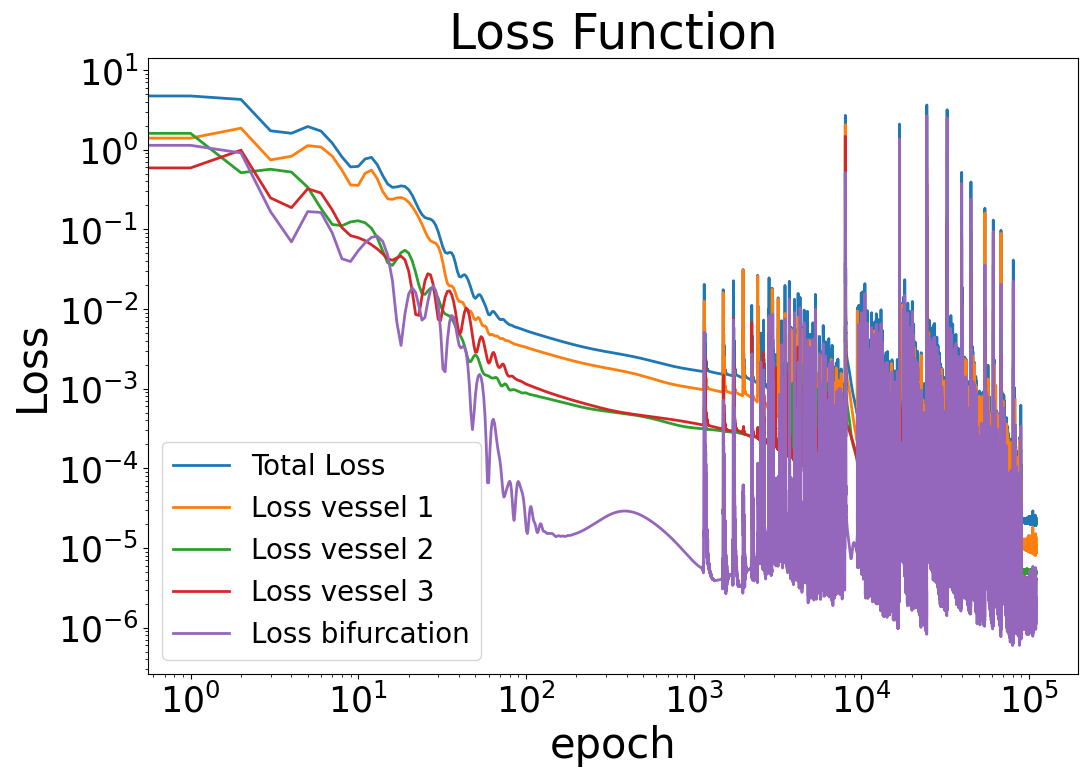

In [88]:
plt.figure(figsize=(12, 8))
plt.title('Loss Function', fontsize = 35)
plt.plot(hist['Loss'], label = 'Total Loss', linewidth = 2)
plt.plot(hist['Loss_1'], label = 'Loss vessel 1', linewidth = 2)
plt.plot(hist['Loss_2'], label = 'Loss vessel 2', linewidth = 2)
plt.plot(hist['Loss_3'], label = 'Loss vessel 3', linewidth = 2)
plt.plot(hist['Loss_inter'], label = 'Loss bifurcation', linewidth = 2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch', fontsize = 30)
plt.xticks(fontsize=25)  # Aumenta el tamaño de los números en el eje x
plt.yticks(fontsize=25)
plt.ylabel('Loss', fontsize = 30)
plt.legend(fontsize = 20)
plt.show()

In [70]:
model_1.save("red_vaso1_5Mar.h5")
model_2.save("red_vaso2_5Mar.h5")
model_3.save("red_vaso3_5Mar.h5")

## Vessel 1

In [89]:
#Graficos 3D
def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('predict Pinns')
    ax.set_xlabel('t', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, X, F_xt,cmap="rainbow")
    ax.set_xlabel('t', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    ax.set_zlabel('', fontsize = 18)
    plt.show()

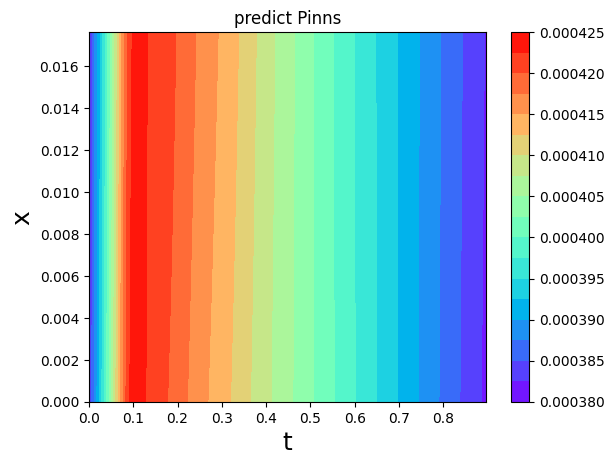

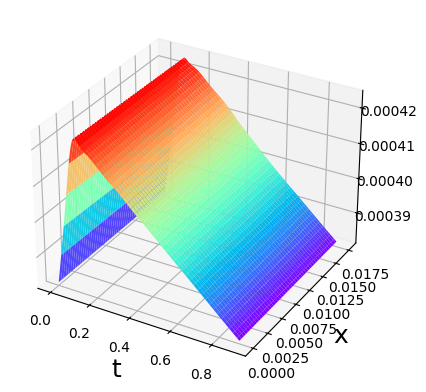

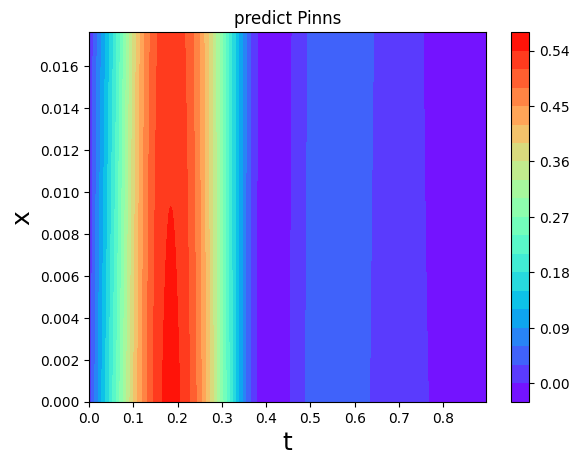

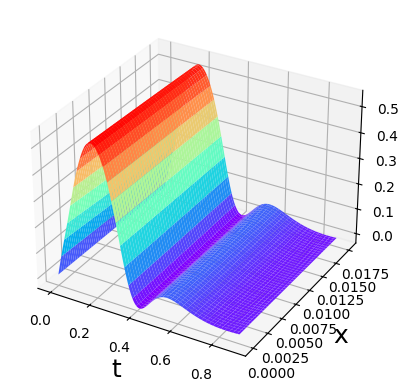

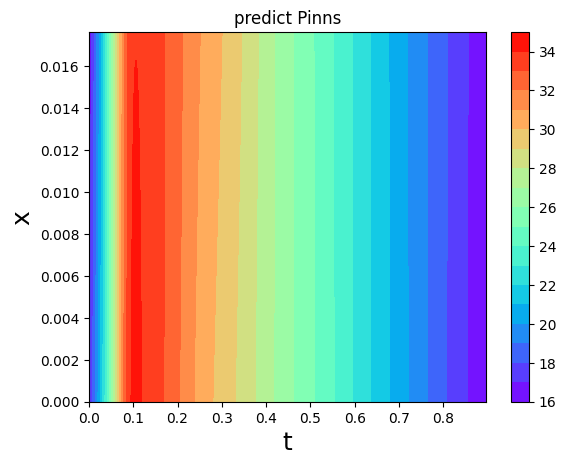

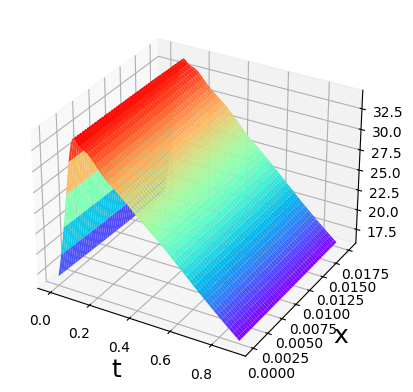

In [90]:
# Vessel 1

N = 1000
T_a = L/U_a
xspace = np.linspace(xmin_1, xmax_1, N + 1)
xspace = xspace*(1/L)
tspace = np.linspace(tmin, tmax, N + 1)
tspace = tspace*(1/T_a)
X, T = np.meshgrid(xspace, tspace)
X_an, T_an = np.meshgrid((xspace -  Xmean1)*jac_x1, (tspace-Tmean1)*jac_t)
Xgrid = np.vstack([X_an.flatten(),T_an.flatten()]).T


A_pred_1 = tf.exp(model_1(tf.cast(Xgrid,DTYPE))[:,0:1])
u_pred_1 = model_1(tf.cast(Xgrid,DTYPE))[:,1:2]
p_pred_1 = model_1(tf.cast(Xgrid,DTYPE))[:,2:3]

A_pred_1 = A_pred_1.numpy().reshape(N+1,N+1)
u_pred_1 = u_pred_1.numpy().reshape(N+1,N+1)
p_pred_1 = p_pred_1.numpy().reshape(N+1,N+1)

# Area
plot3D_Matrix(X*L, T*T_a, A_pred_1*A0)
plot3D_Matrix(X*L, T*T_a, u_pred_1*U_a)
plot3D_Matrix(X*L, T*T_a, p_pred_1*p0*0.00750062)

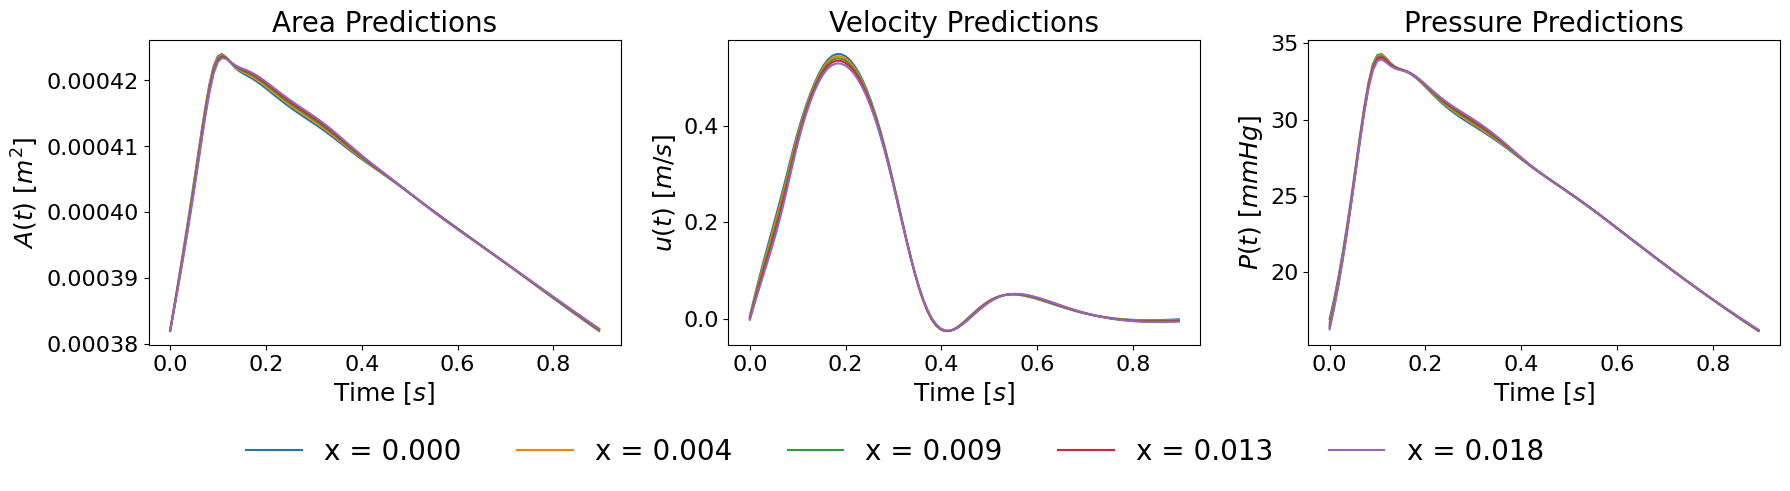

In [107]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N_t = 100
x1_values = np.linspace(xmin_1, xmax_1, 5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

legend_labels = []

for point in x1_values:
    x1 = point * tf.ones(N_t, 1)
    x1_an = (x1 / L - Xmean1) * jac_x1
    x1_an = tf.cast(x1_an, tf.float32)
    x1_an = tf.reshape(x1_an, [-1, 1])

    t_test_1 = tf.linspace(tmin, tmax, N_t)
    t_test_1 = tf.reshape(t_test_1, [-1, 1])
    t_test_1 = tf.cast(t_test_1, tf.float32)
    t_test_1_an = (t_test_1 / T_a - Tmean1) * jac_t
    Xgrid = tf.concat([x1_an, t_test_1_an], axis=1)

    A_pred_x1 = tf.exp(model_1(tf.cast(Xgrid, DTYPE))[:, 0:1])
    u_pred_x1 = model_1(tf.cast(Xgrid, DTYPE))[:, 1:2]
    p_pred_x1 = model_1(tf.cast(Xgrid, DTYPE))[:, 2:3]

    label = 'x = {:.3f}'.format(point)
    legend_labels.append(label)

    axes[0].plot(t_test_1, A_pred_x1 * A0, label=label)
    axes[1].plot(t_test_1, u_pred_x1 * U_a, label=label)
    axes[2].plot(t_test_1, p_pred_x1 * p0 * 0.00750062, label=label)

# Configuración de cada subplot
axes[0].set_xlabel('Time $[s]$', fontsize=18)
axes[0].set_ylabel('$A(t)\,\, [m^2]$', fontsize=18)
axes[0].set_title('Area Predictions', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=16)

axes[1].set_xlabel('Time $[s]$', fontsize=18)
axes[1].set_ylabel('$u(t)\,\, [m/s]$', fontsize=18)
axes[1].set_title('Velocity Predictions', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=16)

axes[2].set_xlabel('Time $[s]$', fontsize=18)
axes[2].set_ylabel('$P(t)\,\,[mmHg]$', fontsize=18)
axes[2].set_title('Pressure Predictions', fontsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=16)

# Ajustar espacio horizontal entre gráficos
plt.subplots_adjust(wspace=0.3)

# Añadir leyenda global abajo de todo
fig.legend(legend_labels, loc='lower center', fontsize=20, ncol=5, frameon=False)

plt.tight_layout()
# Ajustar margen inferior para que quepa la leyenda
plt.subplots_adjust(bottom=0.3)

plt.show()


## Vessel 2

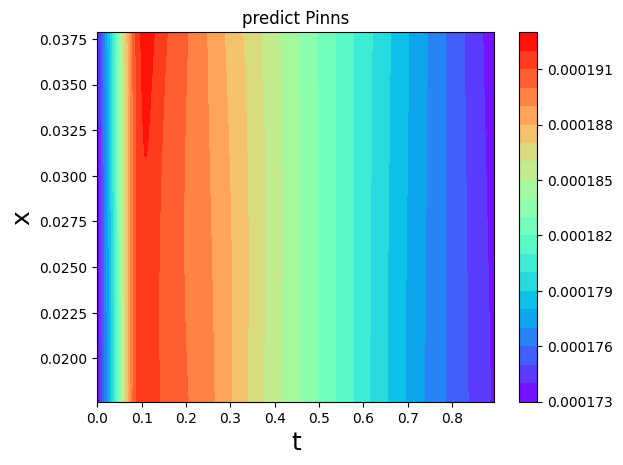

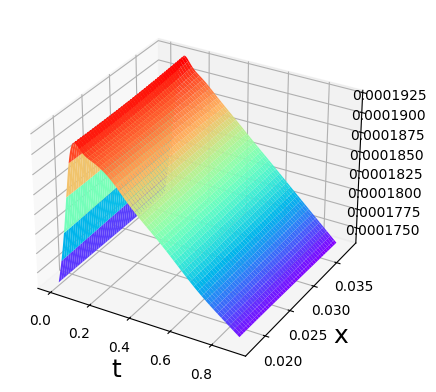

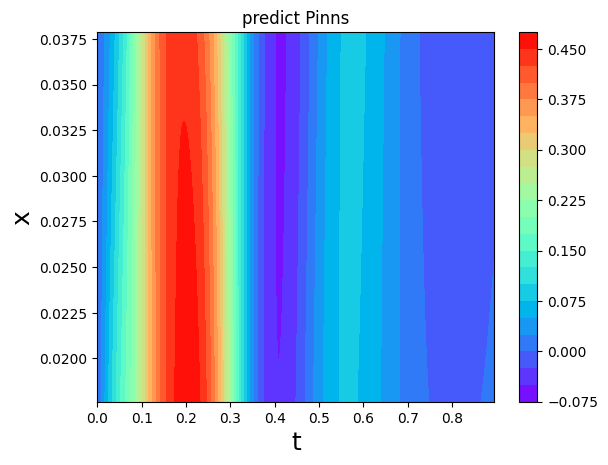

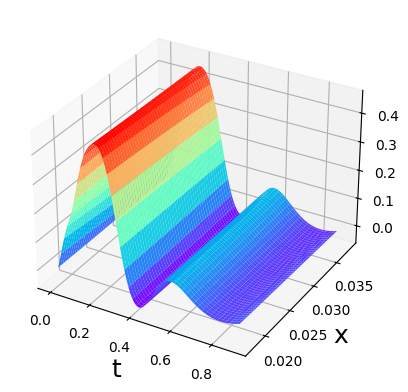

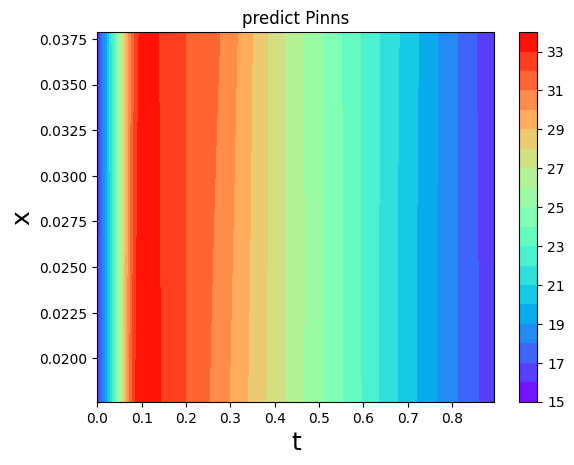

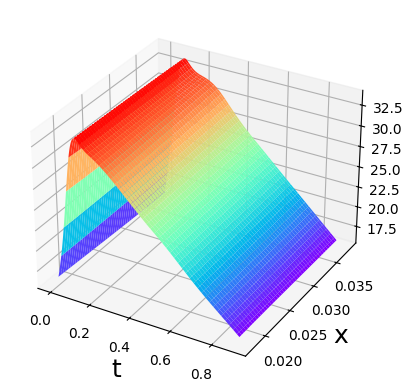

In [75]:
# Vessel 1

N = 1000
T_a = L/U_a
xspace = np.linspace(xmin_2, xmax_2, N + 1)
xspace = xspace*(1/L)
tspace = np.linspace(tmin, tmax, N + 1)
tspace = tspace*(1/T_a)
X, T = np.meshgrid(xspace, tspace)
X_an, T_an = np.meshgrid((xspace -  Xmean2)*jac_x2, (tspace-Tmean2)*jac_t)
Xgrid = np.vstack([X_an.flatten(),T_an.flatten()]).T


A_pred_2 = tf.exp(model_2(tf.cast(Xgrid,DTYPE))[:,0:1])
u_pred_2 = model_2(tf.cast(Xgrid,DTYPE))[:,1:2]
p_pred_2 = model_2(tf.cast(Xgrid,DTYPE))[:,2:3]

A_pred_2 = A_pred_2.numpy().reshape(N+1,N+1)
u_pred_2 = u_pred_2.numpy().reshape(N+1,N+1)
p_pred_2 = p_pred_2.numpy().reshape(N+1,N+1)

# Area
plot3D_Matrix(X*L, T*T_a, A_pred_2*A0)
plot3D_Matrix(X*L, T*T_a, u_pred_2*U_a)
plot3D_Matrix(X*L, T*T_a, p_pred_2*p0*0.00750062)

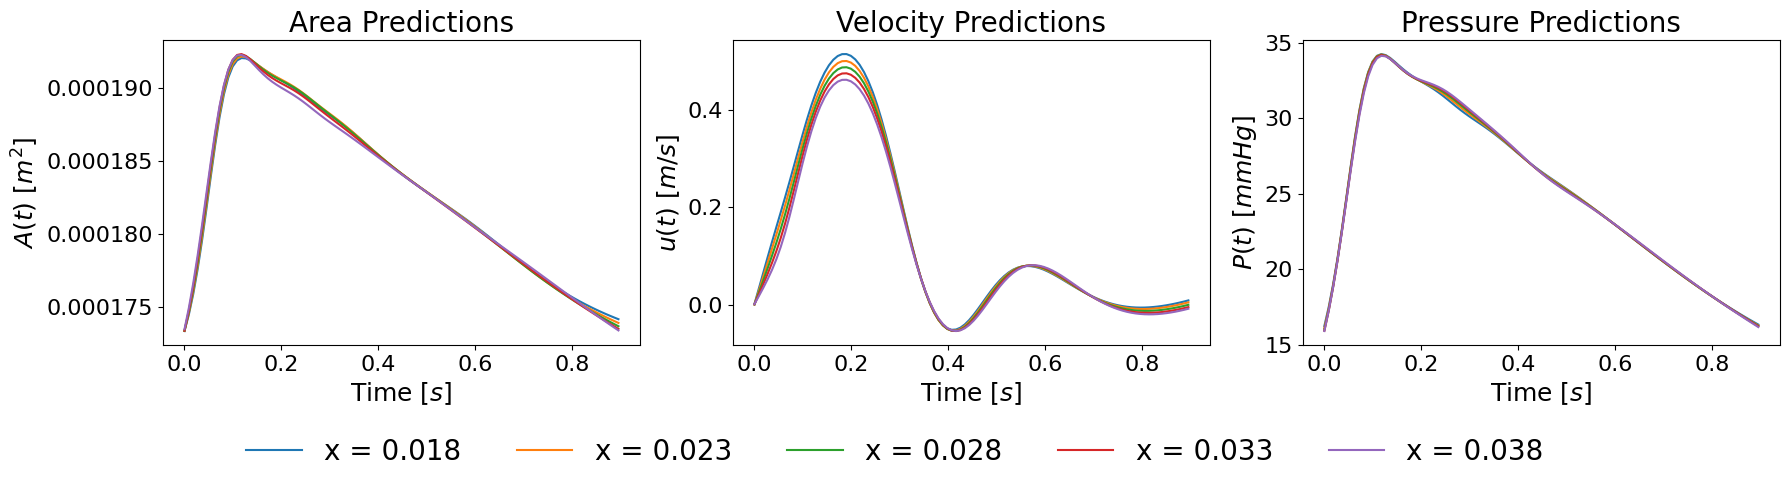

In [106]:
N_t = 100
x1_values = np.linspace(xmin_2, xmax_2, 5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

legend_labels = []

for point in x1_values:
    x1 = point * tf.ones(N_t, 1)
    x1_an = (x1 / L - Xmean2) * jac_x2
    x1_an = tf.cast(x1_an, tf.float32)
    x1_an = tf.reshape(x1_an, [-1, 1])

    t_test_1 = tf.linspace(tmin, tmax, N_t)
    t_test_1 = tf.reshape(t_test_1, [-1, 1])
    t_test_1 = tf.cast(t_test_1, tf.float32)
    t_test_1_an = (t_test_1 / T_a - Tmean1) * jac_t
    Xgrid = tf.concat([x1_an, t_test_1_an], axis=1)

    A_pred_x1 = tf.exp(model_2(tf.cast(Xgrid, DTYPE))[:, 0:1])
    u_pred_x1 = model_2(tf.cast(Xgrid, DTYPE))[:, 1:2]
    p_pred_x1 = model_2(tf.cast(Xgrid, DTYPE))[:, 2:3]

    label = 'x = {:.3f}'.format(point)
    legend_labels.append(label)

    axes[0].plot(t_test_1, A_pred_x1 * A0, label=label)
    axes[1].plot(t_test_1, u_pred_x1 * U_a, label=label)
    axes[2].plot(t_test_1, p_pred_x1 * p0 * 0.00750062, label=label)

# Configuración de cada subplot
axes[0].set_xlabel('Time $[s]$', fontsize=18)
axes[0].set_ylabel('$A(t)\,\, [m^2]$', fontsize=18)
axes[0].set_title('Area Predictions', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=16)

axes[1].set_xlabel('Time $[s]$', fontsize=18)
axes[1].set_ylabel('$u(t)\,\, [m/s]$', fontsize=18)
axes[1].set_title('Velocity Predictions', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=16)

axes[2].set_xlabel('Time $[s]$', fontsize=18)
axes[2].set_ylabel('$P(t)\,\,[mmHg]$', fontsize=18)
axes[2].set_title('Pressure Predictions', fontsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=16)

# Ajustar espacio horizontal entre gráficos
plt.subplots_adjust(wspace=0.3)

# Añadir leyenda global abajo de todo
fig.legend(legend_labels, loc='lower center', fontsize=20, ncol=5, frameon=False)

plt.tight_layout()
# Ajustar margen inferior para que quepa la leyenda
plt.subplots_adjust(bottom=0.3)

plt.show()

## Vessel 3

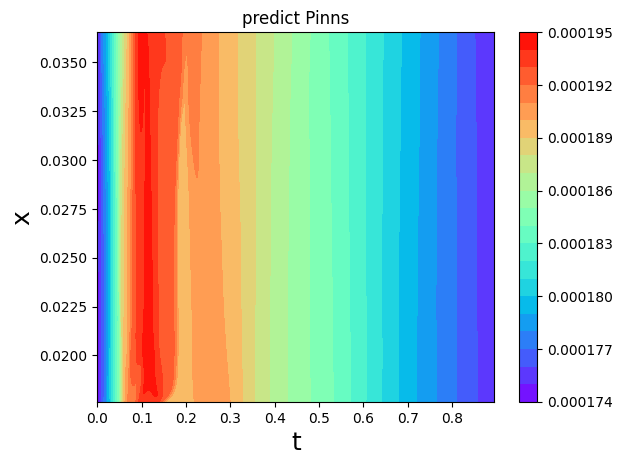

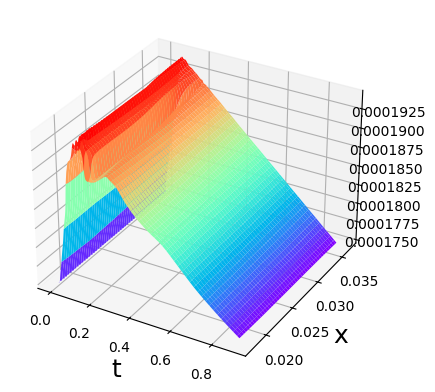

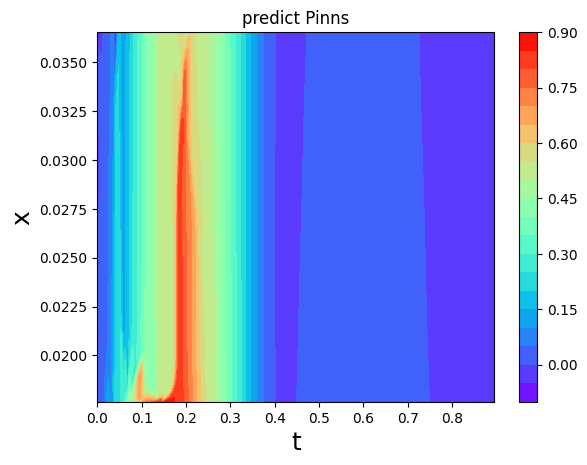

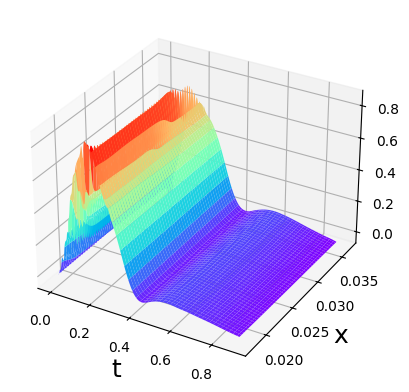

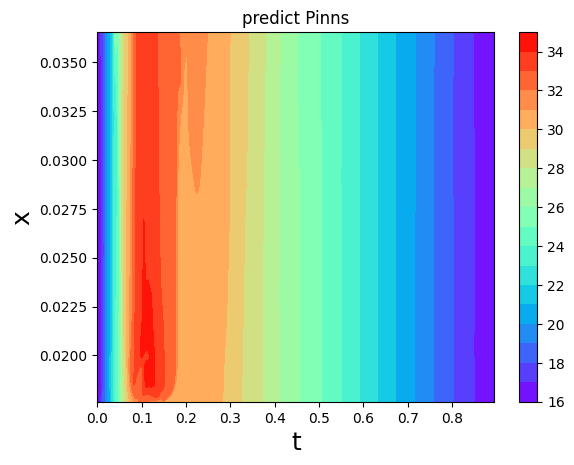

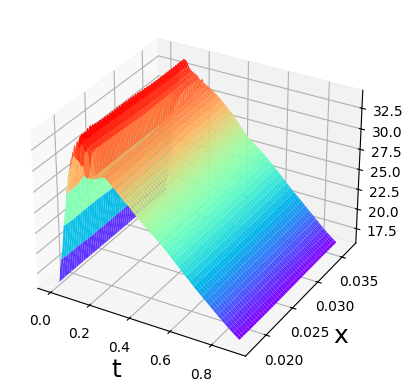

In [76]:
# Vessel 1

N = 1000
T_a = L/U_a
xspace = np.linspace(xmin_3, xmax_3, N + 1)
xspace = xspace*(1/L)
tspace = np.linspace(tmin, tmax, N + 1)
tspace = tspace*(1/T_a)
X, T = np.meshgrid(xspace, tspace)
X_an, T_an = np.meshgrid((xspace -  Xmean3)*jac_x3, (tspace-Tmean3)*jac_t)
Xgrid = np.vstack([X_an.flatten(),T_an.flatten()]).T


A_pred_3 = tf.exp(model_3(tf.cast(Xgrid,DTYPE))[:,0:1])
u_pred_3 = model_3(tf.cast(Xgrid,DTYPE))[:,1:2]
p_pred_3 = model_3(tf.cast(Xgrid,DTYPE))[:,2:3]

A_pred_3 = A_pred_3.numpy().reshape(N+1,N+1)
u_pred_3 = u_pred_3.numpy().reshape(N+1,N+1)
p_pred_3 = p_pred_3.numpy().reshape(N+1,N+1)

# Area
plot3D_Matrix(X*L, T*T_a, A_pred_3*A0)
plot3D_Matrix(X*L, T*T_a, u_pred_3*U_a)
plot3D_Matrix(X*L, T*T_a, p_pred_3*p0*0.00750062)

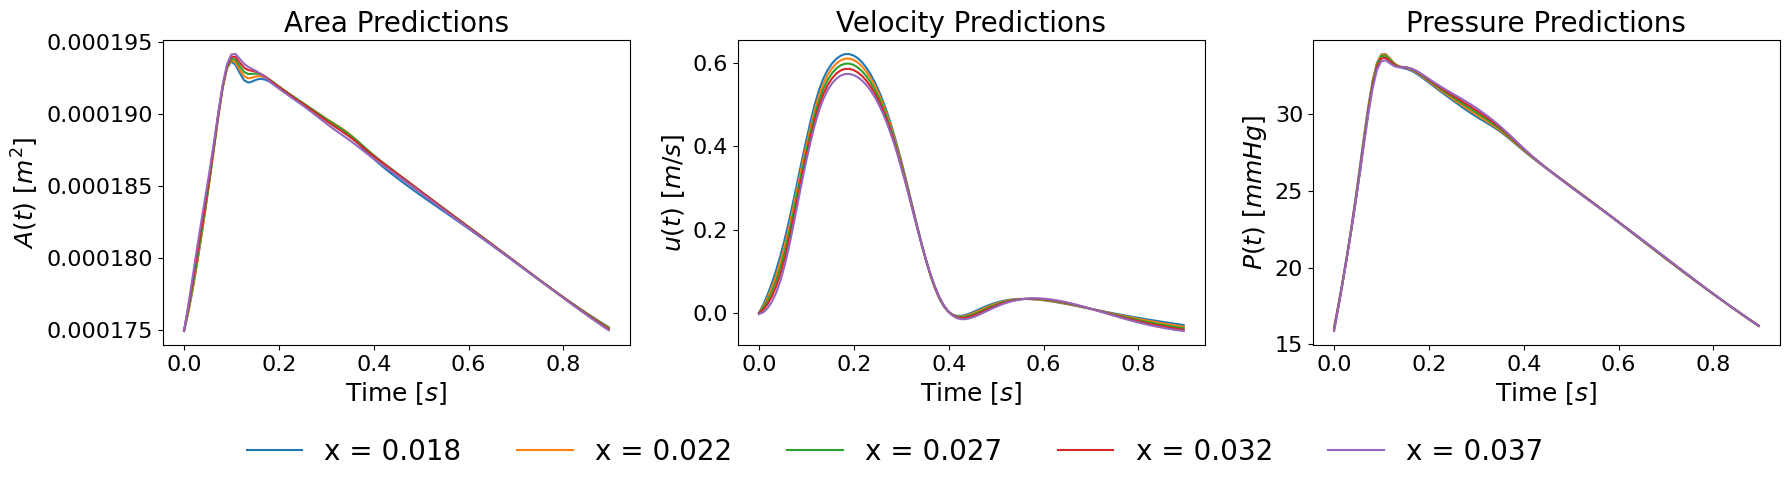

In [105]:
N_t = 100
x1_values = np.linspace(xmin_3, xmax_3, 5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

legend_labels = []

for point in x1_values:
    x1 = point * tf.ones(N_t, 1)
    x1_an = (x1 / L - Xmean3) * jac_x3
    x1_an = tf.cast(x1_an, tf.float32)
    x1_an = tf.reshape(x1_an, [-1, 1])

    t_test_1 = tf.linspace(tmin, tmax, N_t)
    t_test_1 = tf.reshape(t_test_1, [-1, 1])
    t_test_1 = tf.cast(t_test_1, tf.float32)
    t_test_1_an = (t_test_1 / T_a - Tmean1) * jac_t
    Xgrid = tf.concat([x1_an, t_test_1_an], axis=1)

    A_pred_x1 = tf.exp(model_3(tf.cast(Xgrid, DTYPE))[:, 0:1])
    u_pred_x1 = model_3(tf.cast(Xgrid, DTYPE))[:, 1:2]
    p_pred_x1 = model_3(tf.cast(Xgrid, DTYPE))[:, 2:3]

    label = 'x = {:.3f}'.format(point)
    legend_labels.append(label)

    axes[0].plot(t_test_1, A_pred_x1 * A0, label=label)
    axes[1].plot(t_test_1, u_pred_x1 * U_a, label=label)
    axes[2].plot(t_test_1, p_pred_x1 * p0 * 0.00750062, label=label)

# Configuración de cada subplot
axes[0].set_xlabel('Time $[s]$', fontsize=18)
axes[0].set_ylabel('$A(t)\,\, [m^2]$', fontsize=18)
axes[0].set_title('Area Predictions', fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=16)

axes[1].set_xlabel('Time $[s]$', fontsize=18)
axes[1].set_ylabel('$u(t)\,\, [m/s]$', fontsize=18)
axes[1].set_title('Velocity Predictions', fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=16)

axes[2].set_xlabel('Time $[s]$', fontsize=18)
axes[2].set_ylabel('$P(t)\,\,[mmHg]$', fontsize=18)
axes[2].set_title('Pressure Predictions', fontsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=16)

# Ajustar espacio horizontal entre gráficos
plt.subplots_adjust(wspace=0.3)

# Añadir leyenda global abajo de todo
fig.legend(legend_labels, loc='lower center', fontsize=20, ncol=5, frameon=False)

plt.tight_layout()
# Ajustar margen inferior para que quepa la leyenda
plt.subplots_adjust(bottom=0.3)

plt.show()

# Mass Conservation Chart at the Bifurcation

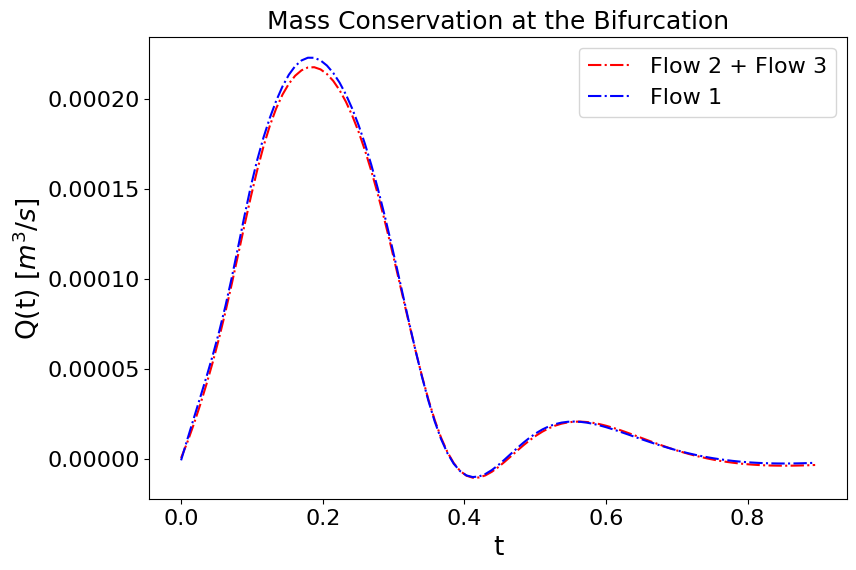

In [108]:
xx2, tt2 = X_r1bif_an[:, 0:1], X_r1bif_an[:,1:2]
test_1_area = tf.exp(model_1(tf.stack([xx2[:,0], tt2[:,0]], axis = 1))[:,0:1])
test_1_vel = model_1(tf.stack([xx2[:,0], tt2[:,0]], axis = 1))[:,1:2]

xx2_2, tt2_2 = X_r2bif_an[:, 0:1], X_r2bif_an[:,1:2]
test_2_area = tf.exp(model_2(tf.stack([xx2_2[:,0], tt2_2[:,0]], axis = 1))[:,0:1])
test_2_vel = model_2(tf.stack([xx2_2[:,0], tt2_2[:,0]], axis = 1))[:,1:2]

xx2_3, tt2_3 = X_r3bif_an[:, 0:1], X_r3bif_an[:,1:2]
test_3_area = tf.exp(model_3(tf.stack([xx2_3[:,0], tt2_3[:,0]], axis = 1))[:,0:1])
test_3_vel = model_3(tf.stack([xx2_3[:,0], tt2_3[:,0]], axis = 1))[:,1:2]


fig, ax = plt.subplots(figsize = (9,6))
plt.title('Mass Conservation at the Bifurcation', fontsize = 18)
ax.plot(t_0,  test_2_vel*U_a*test_2_area*A0 + test_3_vel*U_a*test_3_area*A0, color = 'red', linestyle ='-.', label = 'Flow 2 + Flow 3')
handles, labels = ax.get_legend_handles_labels()
ax.plot(t_0, test_1_vel*U_a*test_1_area*A0, color = 'blue', linestyle ='-.', label = 'Flow 1')
ax.legend(loc = 'upper right', fontsize = 16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('t', fontsize = 19)
ax.set_ylabel('Q(t) [$m^3/s$]', fontsize = 19)
plt.show()
#plt.savefig('Gráfico Conservación de Masa en la Bifurcación', bbox_inches = 'tight')

# Conservation of Momentum Graph at the Bifurcation

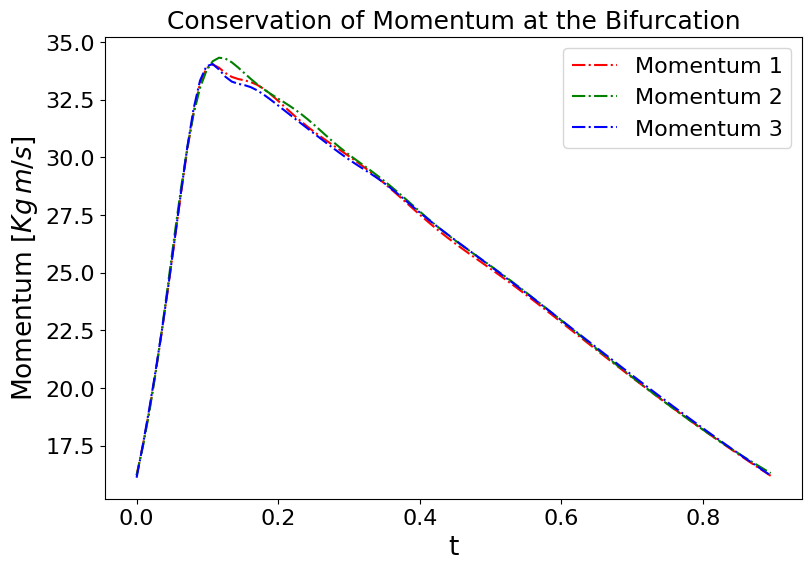

In [109]:
xx2, tt2 = X_r1bif_an[:, 0:1], X_r1bif_an[:,1:2]
test_1_area = tf.exp(model_1(tf.stack([xx2[:,0], tt2[:,0]], axis = 1))[:,0:1])
test_1_vel = model_1(tf.stack([xx2[:,0], tt2[:,0]], axis = 1))[:,1:2]
test_1_pres = model_1(tf.stack([xx2[:,0], tt2[:,0]], axis = 1))[:,2:3]

xx2_2, tt2_2 = X_r2bif_an[:, 0:1], X_r2bif_an[:,1:2]
test_2_area = tf.exp(model_2(tf.stack([xx2_2[:,0], tt2_2[:,0]], axis = 1))[:,0:1])
test_2_vel = model_2(tf.stack([xx2_2[:,0], tt2_2[:,0]], axis = 1))[:,1:2]
test_2_pres = model_2(tf.stack([xx2_2[:,0], tt2_2[:,0]], axis = 1))[:,2:3]

xx2_3, tt2_3 = X_r3bif_an[:, 0:1], X_r3bif_an[:,1:2]
test_3_area = tf.exp(model_3(tf.stack([xx2_3[:,0], tt2_3[:,0]], axis = 1))[:,0:1])
test_3_vel = model_3(tf.stack([xx2_3[:,0], tt2_3[:,0]], axis = 1))[:,1:2]
test_3_pres = model_3(tf.stack([xx2_3[:,0], tt2_3[:,0]], axis = 1))[:,2:3]

fig, ax = plt.subplots(figsize = (9,6))
plt.title('Conservation of Momentum at the Bifurcation', fontsize = 18)
ax.plot(t_0, test_1_pres*p0*0.00750062 + (1/2)*(test_1_vel*U_a)**2 , color = 'red', linestyle ='-.', label = 'Momentum 1')
ax.plot(t_0, test_2_pres*p0*0.00750062 + (1/2)*(test_2_vel*U_a)**2  , color = 'green', linestyle ='-.', label = 'Momentum 2')
handles, labels = ax.get_legend_handles_labels()
ax.plot(t_0, test_3_pres*p0*0.00750062 + (1/2)*(test_3_vel*U_a)**2, color = 'blue', linestyle ='-.', label = 'Momentum 3')
ax.legend(loc = 'upper right', fontsize = 16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_xlabel('t', fontsize = 19)
ax.set_ylabel('Momentum [$Kg \,m/s$]', fontsize = 19)

plt.savefig('Gráfico de Conservación de Momentum en la Bifurcación', bbox_inches = 'tight')
plt.show()
